In [1]:
import set_lib_path
import os
import random

from src.model.data_mappings import \
    filter_counts, load_and_preprocess_counts_data
from src.model.modality import get_modality_objects
from src.model.street_grid.intersections import load_intersections
from src.model.street_grid.street_segments import \
    load_street_segments

from src.model.solve.gurobi_solver import Gurobi_Solver
from src.model.solve.osqp_solver import OSQP_Solver

# General data loading

In [2]:
# load and transform data

data_id = 'test_set' # 'AAA'

data_folder = f'data/managed_data_files/{data_id}'
filename_streets = 'input/street_segments.csv'
filename_intersections = 'input/intersections.csv'

if data_id == 'AAA':
    filename_data = 'input/counts/cropland_2020_01_01.csv'
    timestamp = '2020-01-01 18:00:00+00:00'
elif data_id == 'test_set':
    filename_data = 'input/counts/all_data_small_cropland_velo.csv'
    timestamp = '2020-05-11 12:00:00+00:00'

filename_modality = 'modality_mapping.json'

THIS_DIR = os.getcwd()
data_files_path = os.path.join(THIS_DIR, os.pardir, os.pardir, data_folder)
street_path = os.path.join(data_files_path, filename_streets)
intersections_path = os.path.join(data_files_path, filename_intersections)
data_path = os.path.join(data_files_path, filename_data)
modalities_path = os.path.join(THIS_DIR, os.pardir, os.pardir, 'src/model', filename_modality)

street_segments = load_street_segments(street_path)
intersections = load_intersections(intersections_path)
modality_mapping = get_modality_objects(modalities_path)
counts = load_and_preprocess_counts_data(data_path, modality_mapping, upsampling_frequency='5min')
filtered_counts = filter_counts(counts, street_segments) 

No pickle file found, loading data and applying modality transformations...
Mapping modalities given to this set of final modalities:  ['bg_density', 'bike_density', 'pedestrian_density', 'mot_density']
Upsampling data...
Datasources to be upsampled:  ['cropland']
Upsampling cropland...
Done upsampling!


## Gurobi model solution

In [3]:
solver = Gurobi_Solver(False)
solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
solver.prepare()
solver.update(timestamp)
gurobi_solution = solver.solve_iteration().x

# solver = Gurobi_Solver(True, False)
# solver.set_previous_solution(gurobi_solution)
# solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
# solver.prepare()
# solver.update(timestamp)
# gurobi_solution = solver.solve_iteration().x

solver = Gurobi_Solver(True, True)
solver.set_previous_solution(gurobi_solution)
solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
solver.prepare()
solver.update(timestamp)
gurobi_solution = solver.solve_iteration().x

print('Gurobi solution: ')
print(gurobi_solution.head())

Using license file /home/quent/gurobi.lic
Set parameter TokenServer to value 40.68.207.41
Set parameter TSPort to value 41955
Function 'prepare' executed in 0.1167s
Function 'set_cost_function' executed in 0.0141s
Function 'update_constraints' executed in 0.0109s
Function 'update' executed in 0.0251s
Function 'solve_iteration' executed in 0.0061s
Function 'prepare' executed in 0.1030s
Function 'set_cost_function' executed in 0.0114s
Function 'update_constraints' executed in 0.0125s
Function 'update' executed in 0.0239s
Function 'solve_iteration' executed in 0.0063s
Gurobi solution: 
                                     solution
street_object_id modality                    
1123458          bg_density          0.238965
                 bike_density        0.410807
                 pedestrian_density  0.410807
                 mot_density         0.151665
485896           bg_density          0.236879


# osqp solution

Function 'prepare' executed in 0.0560s
Function 'update_constraints' executed in 0.0183s
Function 'update' executed in 0.0184s
Function 'solve_iteration' executed in 0.0182s
Function 'prepare' executed in 0.0864s
Function 'update_constraints' executed in 0.0216s
Function 'update' executed in 0.0217s
Function 'solve_iteration' executed in 0.0165s

 VARIABLES
  data_source data_source_index               variable  osqp_index
0    cropland            153579  alpha_cropland_153579         460
1    cropland            154079  alpha_cropland_154079         461
     street_object_id            modality  \
0             1123458          bg_density   
1             1123458        bike_density   
2             1123458  pedestrian_density   
3             1123458         mot_density   
4              485896          bg_density   
..                ...                 ...   
455           1076701         mot_density   
456            483118          bg_density   
457            483118        bike_

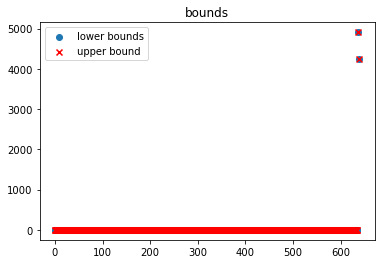

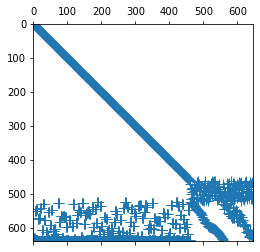

l : 640
u : 640
<class 'scipy.sparse.csc.csc_matrix'>
A : (640, 647)
q: 647


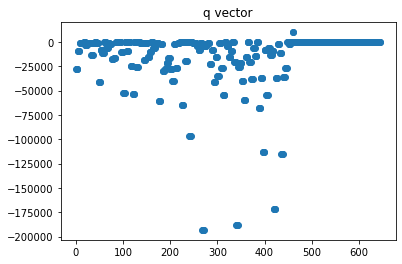

P: (647, 647)


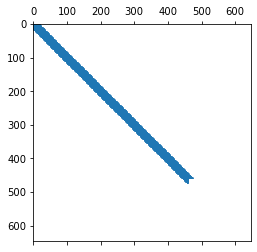

                                     solution
street_object_id modality                    
1123458          bg_density          0.296173
                 bike_density        0.296173
                 pedestrian_density  0.296173
                 mot_density         0.323725
485896           bg_density          0.324447
...                                       ...
1076701          mot_density         0.277804
483118           bg_density          0.152609
                 bike_density        0.258073
                 pedestrian_density  0.258073
                 mot_density         0.134957

[460 rows x 1 columns]
DEBUGGING
   street_object_id            modality  \
0           1123458          bg_density   
1           1123458        bike_density   
2           1123458  pedestrian_density   
3           1123458         mot_density   
4            485896          bg_density   

                                 variable  upper_bound  osqp_index  
0          dens_bg_density_street_112345

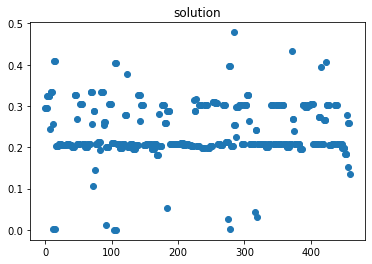

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, lil_matrix, vstack
from pickle import DEFAULT_PROTOCOL
from numpy.core.fromnumeric import shape, var
from numpy.lib.function_base import average

solver = OSQP_Solver(False)
solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
solver.prepare()
# tijd = filtered_counts.get('timestamp').iloc[5]
# timestamp = tijd
# #timestamp = filtered_counts['timestamp'].min()
solver.update(timestamp)
osqp_solution = solver.solve_iteration().x


# solver = OSQP_Solver(True, False)
# solver.set_previous_solution(osqp_solution)
# solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
# solver.prepare()
# solver.update(timestamp)
# osqp_solution = solver.solve_iteration().x


solver = OSQP_Solver(True, True)
solver.set_previous_solution(osqp_solution)
solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
solver.prepare()
solver.update(timestamp)
osqp_solution = solver.solve_iteration().x

# """
# TESTS for the variables
print('\n VARIABLES')
print(solver.alphas)
print(solver.densities)
print(solver.density_deltas)

## TESTS for the constraints

print('\n CONSTRAINTS')
print('df_max_density_constraints:\n',solver.df_max_density_constraints)
print('df_max_alpha_constraints:\n',solver.df_max_alpha_constraints)
print('df_counts_constraints:\n',solver.df_counts_constraints)
print('df_intersection_continuity_constraints:\n',solver.df_intersection_continuity_constraints)
print('df_density_update_constraints:\n',solver.df_density_update_constraints)

if solver.use_previous_solution:
    print('The rhs of the density update constraints are set to -100 to make the indices work')
plt.scatter(np.arange(len(solver.l)),solver.l,label='lower bounds', plotnonfinite=True)
# print(solver.u)
plt.scatter(np.arange(len(solver.u)),solver.u,c='r',marker='x',label='upper bound', plotnonfinite=True)
plt.title('bounds')
plt.legend()
plt.show()
plt.spy(solver.A, marker='+')
plt.show()


# plt.spy(solver.A_density_update_constraints,marker='+')
# plt.show()

print('l :', len(solver.l))
print('u :', len(solver.u))
print(type(solver.A))
print('A :', shape(solver.A))
#"""

print('q:',len(solver.q))
plt.scatter(np.arange(len(solver.q)),solver.q,label='q')
plt.title('q vector')
plt.show()
print('P:',shape(solver.P))
plt.spy(solver.P, marker='+')
plt.show()

print(osqp_solution)

#get a specific modeled value
print('DEBUGGING')
print(solver.densities.head())
street_object_id = 1123458
modality = 'mot_density'
print('The calculated solution for', street_object_id, ' with modality ', modality, ' equals: ', osqp_solution.loc[street_object_id, modality])

#print an output to csv ?

plt.title('solution')
plt.scatter(np.arange(len(osqp_solution)),osqp_solution)
plt.show()

# The merger of density solutions

In [5]:
merged = pd.merge(gurobi_solution, osqp_solution, left_index=True, right_index=True, suffixes=['_gurobi', '_osqp'], how='outer')
merged['unidentified_factor'] = merged['solution_osqp'] / merged['solution_gurobi']
merged.head(25)

solution_gurobi  solution_osqp  \
street_object_id modality                                             
1123458          bg_density                 0.238965       0.296173   
                 bike_density               0.410807       0.296173   
                 pedestrian_density         0.410807       0.296173   
                 mot_density                0.151665       0.323725   
485896           bg_density                 0.236879       0.324447   
                 bike_density               0.415475       0.324447   
                 pedestrian_density         0.415475       0.324447   
                 mot_density                0.150535       0.245027   
472425           bg_density                 0.273226       0.334101   
                 bike_density               0.399950       0.334101   
                 pedestrian_density         0.399950       0.334101   
                 mot_density                0.184971       0.255801   
509335           bg_density                 0.182120       0.001460   
                 bike_density               0.252520       0.409236   
                 pedestrian_density         0.252520       0.409236   
                 mot_density                0.134184       0.001412   
503206           bg_density                 0.189003       0.202309   
                 bike_density               0.231991       0.202309   
                 pedestrian_density         0.231991       0.202309   
                 mot_density                0.156272       0.202309   
470660           bg_density                 0.174049       0.206943   
                 bike_density               0.265949       0.206943   
                 pedestrian_density         0.265949       0.206943   
                 mot_density                0.121830       0.206943   
557150           bg_density                 0.185299       0.204911   

                                     unidentified_factor  
street_object_id modality                                 
1123458          bg_density                     1.239399  
                 bike_density                   0.720955  
                 pedestrian_density             0.720955  
                 mot_density                    2.134471  
485896           bg_density                     1.369673  
                 bike_density                   0.780906  
                 pedestrian_density             0.780906  
                 mot_density                    1.627711  
472425           bg_density                     1.222801  
                 bike_density                   0.835358  
                 pedestrian_density             0.835358  
                 mot_density                    1.382929  
509335           bg_density                     0.008018  
                 bike_density                   1.620609  
                 pedestrian_density             1.620609  
                 mot_density                    0.010523  
503206           bg_density                     1.070403  
                 bike_density                   0.872057  
                 pedestrian_density             0.872057  
                 mot_density                    1.294600  
470660           bg_density                     1.188990  
                 bike_density                   0.778130  
                 pedestrian_density             0.778130  
                 mot_density                    1.698617  
557150           bg_density                     1.105841

## summing the modalities together because the solutions are 'equivalent'

In [6]:
summed = merged.groupby(['street_object_id']).aggregate({'solution_gurobi':sum, 'solution_osqp':sum}).reset_index()
summed.tail(20)

,street_object_id,solution_gurobi,solution_osqp
95,983348,1.219509,1.219511
96,983538,0.830725,0.830721
97,1056142,0.842877,0.842875
98,1076701,0.825815,0.825807
99,1076846,0.824099,0.824091
100,1103700,1.243131,1.243139
101,1103702,0.850113,0.850109
102,1103897,0.548656,0.559292
103,1104480,1.209362,1.209363
104,1104552,0.801861,0.801836


In [7]:
gurobi_solution.shape

(460, 1)

In [8]:
osqp_solution.shape

(460, 1)

In [9]:
output_file = '../../data/output_debugging'
filename = 'output.csv'
merged.to_csv(os.path.join(output_file, filename))

# visualising the result of the modelling

In [10]:
import set_lib_path

import geopandas as gpd
import os

from keplergl import KeplerGl
from src.model.results import load_results
from src.model.street_grid.street_segments import load_street_segments

In [11]:
street_geometries = street_segments[['street_object_id', 'street_object_geometry']].drop_duplicates(['street_object_id'])
result = merged.reset_index()
chosen_modality = 'mot_density'
result = result.loc[result['modality'] == chosen_modality]
indexed_results = result.set_index('street_object_id')

In [12]:
indexed_results['geometry'] = street_geometries.set_index('street_object_id')['street_object_geometry']
df = indexed_results.reset_index()
gdf = gpd.GeoDataFrame(df)

In [13]:
kepler_map_config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "1hy7ule",
          "type": "geojson",
          "config": {
            "dataId": "density",
            "label": "tha",
            "color": [
              255,
              203,
              153
            ],
            "highlightColor": [
              252,
              242,
              26,
              255
            ],
            "columns": {
              "geojson": "geometry"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "strokeOpacity": 0.8,
              "thickness": 0.5,
              "strokeColor": None,
                "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#FFC300",
                  "#F1920E",
                  "#E3611C",
                  "#C70039",
                  "#900C3F",
                  "#5A1846"
                ],
                "reversed": True
              },
              "radius": 10,
              "sizeRange": [
                0,
                10
              ],
              "radiusRange": [
                0,
                50
              ],
              "heightRange": [
                0,
                500
              ],
              "elevationScale": 5,
              "enableElevationZoomFactor": True,
              "stroked": True,
              "filled": False,
              "enable3d": False,
              "wireframe": False
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantile",
            "strokeColorField": {
              "name": "all_density",
              "type": "real"
            },
            "strokeColorScale": "quantile",
            "sizeField": None,
            "sizeScale": "linear",
            "heightField": None,
            "heightScale": "linear",
            "radiusField": None,
            "radiusScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "hdj97cb5cr": [
              {
                "name": "0",
                "format": None
              },
              {
                "name": "street_object_id",
                "format": None
              },
              {
                "name": "timestamp",
                "format": None
              },
              {
                "name": "all_density",
                "format": None
              },
              {
                "name": "bg_density",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 51.25807892455353,
      "longitude": 4.290668485118513,
      "pitch": 0,
      "zoom": 10.614042845402928,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [14]:
kepler_map = KeplerGl(height=650)
kepler_map.config = kepler_map_config
kepler_map.add_data(data=gdf, name="solution")

kepler_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '1hy7ule', 'type': …

## Compare objective values of the solvers

### Retrieve the timestamps

In [15]:
unique_timestamps = [ts for ts in filtered_counts['timestamp'].unique()]
unique_timestamps.sort()

### Helper functions

In [16]:
def instantiante_model(solver_class, **kwargs):
    solver = solver_class(**kwargs)
    solver.load_data(filtered_counts, street_segments, intersections, modality_mapping)
    solver.prepare()
    return solver

def instantiante_models(**kwargs):
    return {
        'gurobi': instantiante_model(Gurobi_Solver, **kwargs),
        'osqp': instantiante_model(OSQP_Solver, **kwargs)
    }

def execute_solver(solver, timestamp, previous_solution=None):
    if previous_solution is not None:
        solver.set_previous_solution(previous_solution)
    solver.update(timestamp)
    return solver.solve_iteration()

def execute_solvers(solvers, **kwargs):
    res = {}
    for solver_name in solvers:
        solver = solvers[solver_name]
        res[solver_name] = execute_solver(solver, **kwargs)
    return res

### Instantiate the solvers

In [17]:
solvers_1 = instantiante_models(use_previous_solution=False)
solvers_2 = instantiante_models(use_previous_solution=True, modality_mixing=False)
solvers_3 = instantiante_models(use_previous_solution=True, modality_mixing=True)

Function 'prepare' executed in 0.0803s
Function 'prepare' executed in 0.0505s
Function 'prepare' executed in 0.1284s
Function 'prepare' executed in 0.1178s
Function 'prepare' executed in 0.0980s
Function 'prepare' executed in 0.0843s


### Configure & Prepare for the tests

In [18]:
n_tests = 10
objective_values = []

### Compare the solvers_1

In [19]:
timestamps = random.sample(unique_timestamps, n_tests)
for timestamp in timestamps:
    res = execute_solvers(solvers_1, timestamp=timestamp)
    objective_values.append({ 'type': 'solvers_1', 'gurobi': res['gurobi'].obj_val, 'osqp': res['osqp'].obj_val })

Function 'set_cost_function' executed in 0.0283s
Function 'update_constraints' executed in 0.0163s
Function 'update' executed in 0.0448s
Function 'solve_iteration' executed in 0.0056s
Function 'update_constraints' executed in 0.0197s
Function 'update' executed in 0.0198s
Function 'solve_iteration' executed in 0.0189s
Function 'set_cost_function' executed in 0.0112s
Function 'update_constraints' executed in 0.0085s
Function 'update' executed in 0.0199s
Function 'solve_iteration' executed in 0.0047s
Function 'update_constraints' executed in 0.0169s
Function 'update' executed in 0.0169s
Function 'solve_iteration' executed in 0.0151s
Function 'set_cost_function' executed in 0.0121s
Function 'update_constraints' executed in 0.0089s
Function 'update' executed in 0.0212s
Function 'solve_iteration' executed in 0.0047s
Function 'update_constraints' executed in 0.0179s
Function 'update' executed in 0.0180s
Function 'solve_iteration' executed in 0.0149s
Function 'set_cost_function' executed in 0.

### Compare the solvers_2 & solvers_3

In [20]:
indexes = random.sample(range(len(unique_timestamps) - 2), n_tests)
for index in indexes:
    reference_timestamp = unique_timestamps[index]
    reference_solution = execute_solver(solvers_1['gurobi'], reference_timestamp).x

    test_timestamp = unique_timestamps[index + 1]
    
    res = execute_solvers(solvers_2, timestamp=test_timestamp, previous_solution=reference_solution)
    objective_values.append({ 'type': 'solvers_2', 'gurobi': res['gurobi'].obj_val, 'osqp': res['osqp'].obj_val })

    test_timestamp = unique_timestamps[index + 2]
    reference_solution = res['gurobi'].x

    res = execute_solvers(solvers_3, timestamp=test_timestamp, previous_solution=reference_solution)
    objective_values.append({ 'type': 'solvers_3', 'gurobi': res['gurobi'].obj_val, 'osqp': res['osqp'].obj_val })

Function 'set_cost_function' executed in 0.0177s
Function 'update_constraints' executed in 0.0100s
Function 'update' executed in 0.0279s
Function 'solve_iteration' executed in 0.0047s
Function 'set_cost_function' executed in 0.0121s
Function 'update_constraints' executed in 0.0176s
Function 'update' executed in 0.0298s
Function 'solve_iteration' executed in 0.0087s
Function 'update_constraints' executed in 0.0203s
Function 'update' executed in 0.0204s
Function 'solve_iteration' executed in 0.0190s
Function 'set_cost_function' executed in 0.0109s
Function 'update_constraints' executed in 0.0114s
Function 'update' executed in 0.0224s
Function 'solve_iteration' executed in 0.0060s
Function 'update_constraints' executed in 0.0217s
Function 'update' executed in 0.0217s
Function 'solve_iteration' executed in 0.0163s
Function 'set_cost_function' executed in 0.0111s
Function 'update_constraints' executed in 0.0089s
Function 'update' executed in 0.0201s
Function 'solve_iteration' executed in 0.

### Comparison

In [21]:
df = pd.DataFrame.from_records(objective_values)
df['abs_error'] = (df['gurobi'] - df['osqp']).abs()
df['rel_error'] = (df['abs_error'] / df['gurobi']).abs()
df.sort_values(by='rel_error', ascending=False)

,type,gurobi,osqp,abs_error,rel_error
20,solvers_2,-1.236766e+06,-1.236760e+06,5.831503,4.715122e-06
22,solvers_2,-8.958375e+05,-8.958350e+05,2.508130,2.799760e-06
0,solvers_1,-8.303499e+05,-8.303477e+05,2.144641,2.582816e-06
18,solvers_2,-8.104034e+05,-8.104024e+05,0.979785,1.209009e-06
14,solvers_2,-7.970556e+05,-7.970548e+05,0.877364,1.100756e-06
16,solvers_2,-1.034854e+06,-1.034853e+06,1.026116,9.915570e-07
23,solvers_3,-8.993675e+05,-8.993670e+05,0.441493,4.908928e-07
26,solvers_2,-9.018753e+05,-9.018749e+05,0.441472,4.895041e-07
15,solvers_3,-8.018489e+05,-8.018486e+05,0.254230,3.170543e-07
27,solvers_3,-9.053168e+05,-9.053166e+05,0.230704,2.548321e-07
